In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In this project, I would like to create a model that predicts a house's price. 

In [2]:
data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.shape

(1460, 81)

First off, I need to see what data is currently missing.

In [4]:
sum_null = data.isna().sum()
sum_null

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [5]:
sum_null[sum_null != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

From the above output and the description of those columns, LotFrontage, MasVnrArea, and GarageYrBlt are the only numerical features. The others are all categorical. Moreover, it seems like most of the null values aren't missing, but rather misrepresented. For instance, the "null values" in the column Alley represents that there are no alley access. The only columns that appear to actually having missing values are LotFrontage, MasVnrArea, Electrical, and GarageYrBlt.

In [6]:
def alley_replace(dataframe):
    replacement = {'Alley' : {
        'Grvl' : 'Gravel',
        'Pave' : 'Paved',
        np.nan : 'No alley access'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe
#Replace 'Nan' values with 'No alley access'

In [7]:
data = alley_replace(data)
data['Alley'].value_counts()

No alley access    1369
Gravel               50
Paved                41
Name: Alley, dtype: int64

In [8]:
sum_null = data.isna().sum()
sum_null[sum_null != 0]

LotFrontage      259
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

The column Alley is not there anymore after we replaced the missing values with the appropriate value. We will do the same for the rest of the columns that have misrepresented null values.

In [9]:
def masvnrtype_replace(dataframe):
    replacement = {'MasVnrType' : {
        'BrkCmn' : 'Brick Common',
        'BrkFace' : 'Brick Face',
        'CBlock' : 'Cinder Block',
        'Stone' : 'Stone',
        np.nan : 'None'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def bsmtqual_replace(dataframe):
    replacement = {'BsmtQual' : {
        'Ex' : 'Excellent',
        'Gd' : 'Good',
        'TA' : 'Average',
        'Fa' : 'Fair',
        'Po' : 'Poor',
        np.nan : 'No Basement'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def bsmtcond_replace(dataframe):
    replacement = {'BsmtCond' : {
        'Ex' : 'Excellent',
        'Gd' : 'Good',
        'TA' : 'Average',
        'Fa' : 'Fair',
        'Po' : 'Poor',
        np.nan : 'No Basement'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def bsmtexp_replace(dataframe):
    replacement = {'BsmtExposure' : {
        'Gd' : 'Good Exposure',
        'Av' : 'Average Exposure',
        'Mn' : 'Minimum Exposure',
        'No' : 'No Exposure',
        np.nan : 'No Basement'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def bsmtfin1_replace(dataframe):
    replacement = {'BsmtFinType1' : {
        'GLQ' : 'Good Living Quarters',
        'ALQ' : 'Average Living Quarters',
        'BLQ' : 'Below Average Living Quarters',
        'Rec' : 'Average Rec Room',
        'LwQ' : 'Low Quality',
        'Unf' : 'Unfinished',
        np.nan : 'No Basement'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def bsmtfin2_replace(dataframe):
    replacement = {'BsmtFinType2' : {
        'GLQ' : 'Good Living Quarters',
        'ALQ' : 'Average Living Quarters',
        'BLQ' : 'Below Average Living Quarters',
        'Rec' : 'Average Rec Room',
        'LwQ' : 'Low Quality',
        'Unf' : 'Unfinished',
        np.nan : 'No Basement'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def fireplacequ_replace(dataframe):
    replacement = {'FireplaceQu' : {
        'Ex' : 'Excellent',
        'Gd' : 'Good',
        'TA' : 'Average',
        'Fa' : 'Fair',
        'Po' : 'Poor',
        np.nan : 'No Fireplace'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def garagetype_replace(dataframe):
    replacement = {'GarageType' : {
        '2Types' : 'More than one type',
        'Attchd' : 'Attached',
        'Basement' : 'Basment Garage',
        'Builtin' : 'Built-in',
        'CarPort' : 'Car Port',
        'Detchd' : 'Detached',
        np.nan : 'No Garage'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def garagefin_replace(dataframe):
    replacement = {'GarageFinish' : {
        'Fin' : 'Finished',
        'RFn' : 'Rough Finished',
        'Unf' : 'Unfinished',
        np.nan : 'No Garage'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def garagequal_replace(dataframe):
    replacement = {'GarageQual' : {
        'Ex' : 'Excellent',
        'Gd' : 'Good',
        'TA' : 'Average',
        'Fa' : 'Fair',
        'Po' : 'Poor',
        np.nan : 'No Garage'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def garagecond_replace(dataframe):
    replacement = {'GarageCond' : {
        'Ex' : 'Excellent',
        'Gd' : 'Good',
        'TA' : 'Average',
        'Fa' : 'Fair',
        'Po' : 'Poor',
        np.nan : 'No Garage'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def poolqc_replace(dataframe):
    replacement = {'PoolQC' : {
        'Ex' : 'Excellent',
        'Gd' : 'Good',
        'TA' : 'Average',
        'Fa' : 'Fair',
        np.nan : 'No Pool'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def fence_replace(dataframe):
    replacement = {'Fence' : {
        'GdPrv' : 'Good Privacy',
        'MnPrv' : 'Minimum Privacy',
        'GdWo' : 'Good Wood',
        'MnWw' : 'Minimum Wood',
        np.nan : 'No Fence'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

def misc_replace(dataframe):
    replacement = {'MiscFeature' : {
        'Elev' : 'Elevator',
        'Gar2' : '2nd Garage',
        'Othr' : 'Other',
        'Shed' : 'Shed',
        'TenC' : 'Tennis Court',
        np.nan : 'None'
    }}
    dataframe = dataframe.replace(replacement)
    return dataframe

In [10]:
data = masvnrtype_replace(data)
data = bsmtqual_replace(data)
data = bsmtcond_replace(data)
data = bsmtexp_replace(data)
data = bsmtfin1_replace(data)
data = bsmtfin2_replace(data)
data = fireplacequ_replace(data)
data = garagetype_replace(data)
data = garagefin_replace(data)
data = garagequal_replace(data)
data = garagecond_replace(data)
data = poolqc_replace(data)
data = fence_replace(data)
data = misc_replace(data)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No alley access,Reg,Lvl,AllPub,...,0,No Pool,No Fence,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No alley access,Reg,Lvl,AllPub,...,0,No Pool,No Fence,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No alley access,IR1,Lvl,AllPub,...,0,No Pool,No Fence,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No alley access,IR1,Lvl,AllPub,...,0,No Pool,No Fence,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No alley access,IR1,Lvl,AllPub,...,0,No Pool,No Fence,None,0,12,2008,WD,Normal,250000


In [11]:
sum_null = data.isna().sum()
sum_null[sum_null != 0]

LotFrontage    259
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64

The column LotFrontage has a lot of missing values so it'd be a bad idea to remove all the rows that have the missing values. Thus, I've decided to replace those missing values with the average value of LotFrontage (this process is known as mean imputation).

In [12]:
lot_average = data['LotFrontage'].mean()
lot_average

70.04995836802665

In [13]:
data['LotFrontage'].fillna(lot_average, inplace = True)

In [14]:
sum_null = data.isna().sum()
sum_null[sum_null != 0]

MasVnrArea      8
Electrical      1
GarageYrBlt    81
dtype: int64

The rest of the columns that have missing values aren't significant for our purpose for this project. We can just remove those columns from our dataset. 

In [15]:
data.drop(['MasVnrArea', 'Electrical', 'GarageYrBlt'], inplace = True, axis = 1)

In [16]:
sum_null = data.isna().sum()
sum_null[sum_null != 0]

Series([], dtype: int64)

There are no more missing values in our dataset! We can move on to our next phase which is exploratory data analysis. For the next part, let's visualize the SalePrice column since that is the value we want to predict.

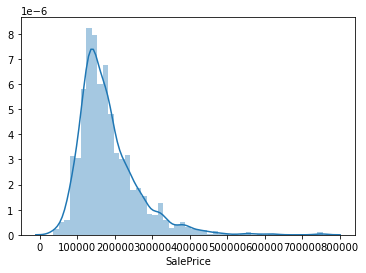

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data["SalePrice"]);

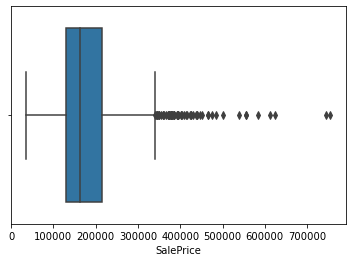

In [18]:
sns.boxplot(x = 'SalePrice', data = data);

In [22]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPo

In [23]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No alley access,Reg,Lvl,AllPub,...,0,No Pool,No Fence,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No alley access,Reg,Lvl,AllPub,...,0,No Pool,No Fence,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No alley access,IR1,Lvl,AllPub,...,0,No Pool,No Fence,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No alley access,IR1,Lvl,AllPub,...,0,No Pool,No Fence,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No alley access,IR1,Lvl,AllPub,...,0,No Pool,No Fence,None,0,12,2008,WD,Normal,250000


Now, let's visualize some of our categorical features.

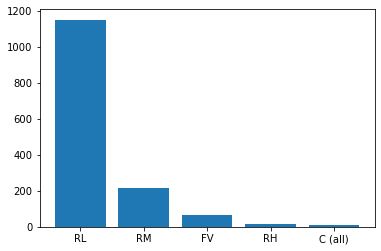

In [32]:
plt.bar(x = list(data['MSZoning'].value_counts().reset_index()['index']), 
        height = list(data['MSZoning'].value_counts().reset_index()['MSZoning']));

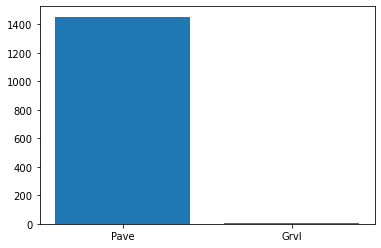

In [33]:
plt.bar(x = list(data['Street'].value_counts().reset_index()['index']), 
        height = list(data['Street'].value_counts().reset_index()['Street']));

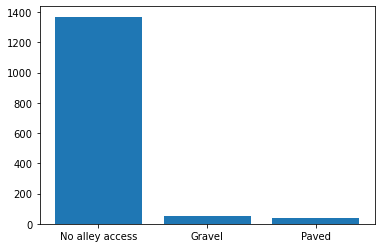

In [34]:
plt.bar(x = list(data['Alley'].value_counts().reset_index()['index']), 
        height = list(data['Alley'].value_counts().reset_index()['Alley']));

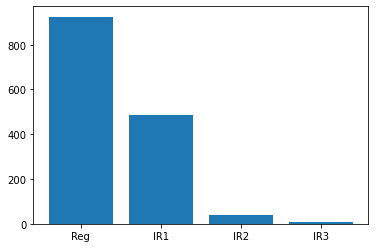

In [35]:
plt.bar(x = list(data['LotShape'].value_counts().reset_index()['index']), 
        height = list(data['LotShape'].value_counts().reset_index()['LotShape']));

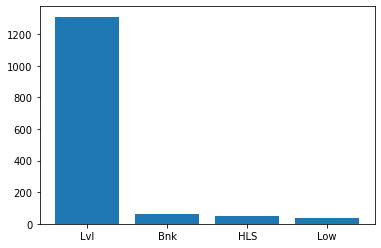

In [36]:
plt.bar(x = list(data['LandContour'].value_counts().reset_index()['index']), 
        height = list(data['LandContour'].value_counts().reset_index()['LandContour']));

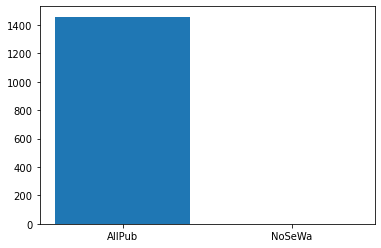

In [37]:
plt.bar(x = list(data['Utilities'].value_counts().reset_index()['index']), 
        height = list(data['Utilities'].value_counts().reset_index()['Utilities']));

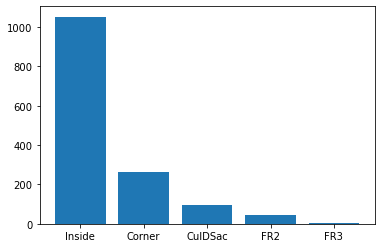

In [38]:
plt.bar(x = list(data['LotConfig'].value_counts().reset_index()['index']), 
        height = list(data['LotConfig'].value_counts().reset_index()['LotConfig']));

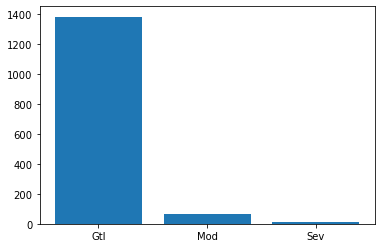

In [39]:
plt.bar(x = list(data['LandSlope'].value_counts().reset_index()['index']), 
        height = list(data['LandSlope'].value_counts().reset_index()['LandSlope']));

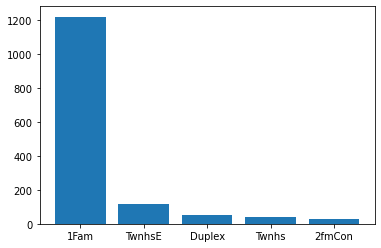

In [40]:
plt.bar(x = list(data['BldgType'].value_counts().reset_index()['index']), 
        height = list(data['BldgType'].value_counts().reset_index()['BldgType']));

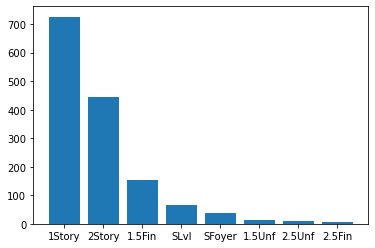

In [41]:
plt.bar(x = list(data['HouseStyle'].value_counts().reset_index()['index']), 
        height = list(data['HouseStyle'].value_counts().reset_index()['HouseStyle']));

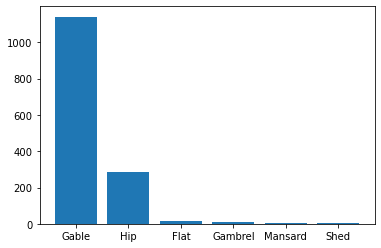

In [42]:
plt.bar(x = list(data['RoofStyle'].value_counts().reset_index()['index']), 
        height = list(data['RoofStyle'].value_counts().reset_index()['RoofStyle']));

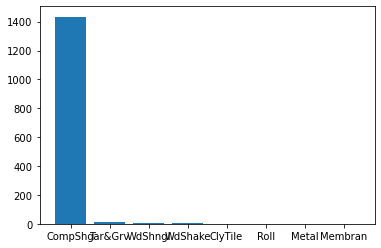

In [43]:
plt.bar(x = list(data['RoofMatl'].value_counts().reset_index()['index']), 
        height = list(data['RoofMatl'].value_counts().reset_index()['RoofMatl']));

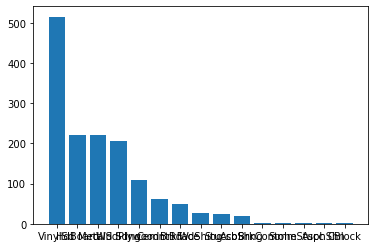

In [44]:
plt.bar(x = list(data['Exterior1st'].value_counts().reset_index()['index']), 
        height = list(data['Exterior1st'].value_counts().reset_index()['Exterior1st']));

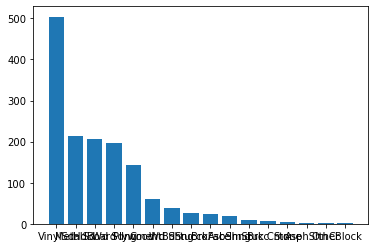

In [45]:
plt.bar(x = list(data['Exterior2nd'].value_counts().reset_index()['index']), 
        height = list(data['Exterior2nd'].value_counts().reset_index()['Exterior2nd']));

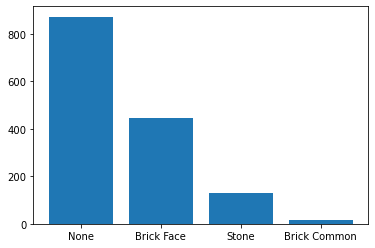

In [48]:
plt.bar(x = list(data['MasVnrType'].value_counts().reset_index()['index']), 
        height = list(data['MasVnrType'].value_counts().reset_index()['MasVnrType']));

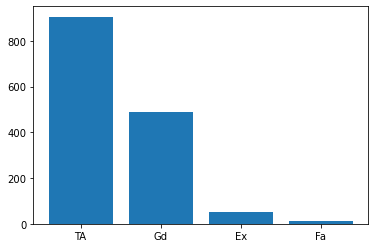

In [49]:
plt.bar(x = list(data['ExterQual'].value_counts().reset_index()['index']), 
        height = list(data['ExterQual'].value_counts().reset_index()['ExterQual']));

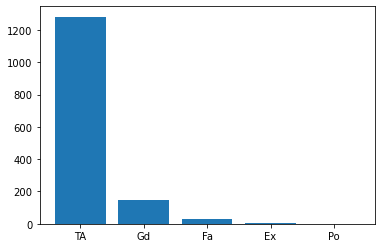

In [50]:
plt.bar(x = list(data['ExterCond'].value_counts().reset_index()['index']), 
        height = list(data['ExterCond'].value_counts().reset_index()['ExterCond']));

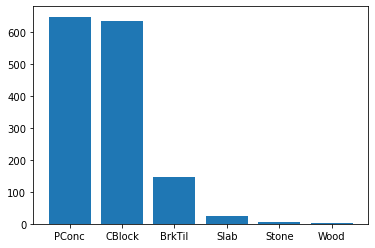

In [51]:
plt.bar(x = list(data['Foundation'].value_counts().reset_index()['index']), 
        height = list(data['Foundation'].value_counts().reset_index()['Foundation']));

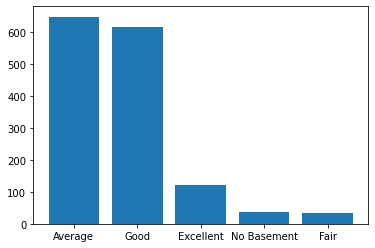

In [52]:
plt.bar(x = list(data['BsmtQual'].value_counts().reset_index()['index']), 
        height = list(data['BsmtQual'].value_counts().reset_index()['BsmtQual']));

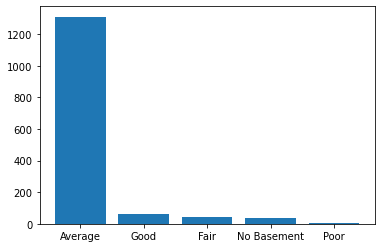

In [54]:
plt.bar(x = list(data['BsmtCond'].value_counts().reset_index()['index']), 
        height = list(data['BsmtCond'].value_counts().reset_index()['BsmtCond']));

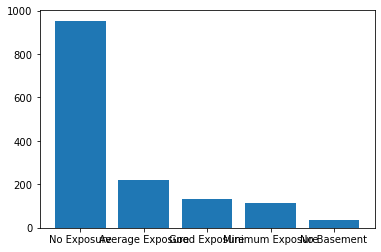

In [57]:
plt.bar(x = list(data['BsmtExposure'].value_counts().reset_index()['index']), 
        height = list(data['BsmtExposure'].value_counts().reset_index()['BsmtExposure']));

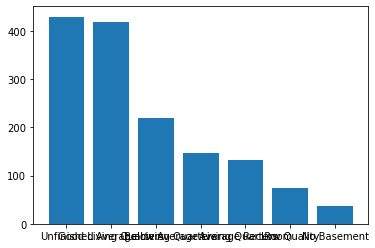

In [58]:
plt.bar(x = list(data['BsmtFinType1'].value_counts().reset_index()['index']), 
        height = list(data['BsmtFinType1'].value_counts().reset_index()['BsmtFinType1']));

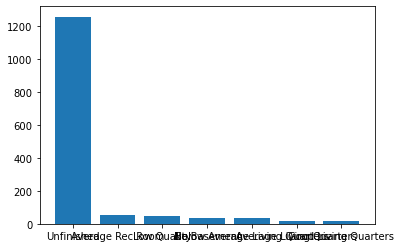

In [59]:
plt.bar(x = list(data['BsmtFinType2'].value_counts().reset_index()['index']), 
        height = list(data['BsmtFinType2'].value_counts().reset_index()['BsmtFinType2']));

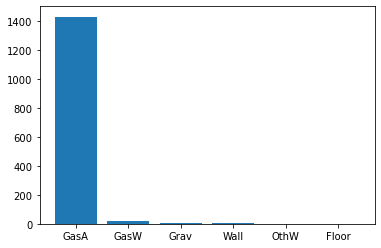

In [60]:
plt.bar(x = list(data['Heating'].value_counts().reset_index()['index']), 
        height = list(data['Heating'].value_counts().reset_index()['Heating']));

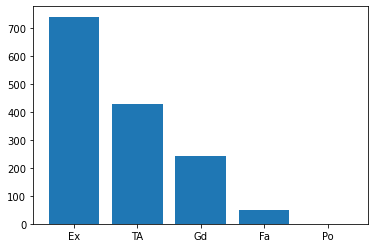

In [61]:
plt.bar(x = list(data['HeatingQC'].value_counts().reset_index()['index']), 
        height = list(data['HeatingQC'].value_counts().reset_index()['HeatingQC']));

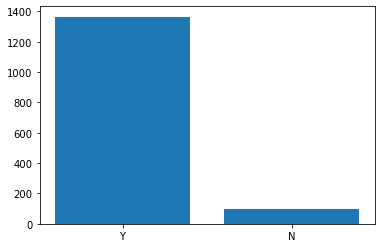

In [63]:
plt.bar(x = list(data['CentralAir'].value_counts().reset_index()['index']), 
        height = list(data['CentralAir'].value_counts().reset_index()['CentralAir']));

In [65]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPo

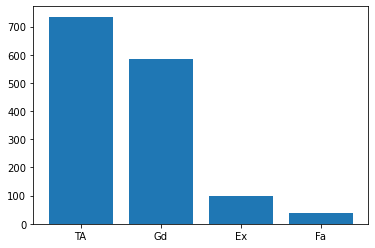

In [66]:
plt.bar(x = list(data['KitchenQual'].value_counts().reset_index()['index']), 
        height = list(data['KitchenQual'].value_counts().reset_index()['KitchenQual']));

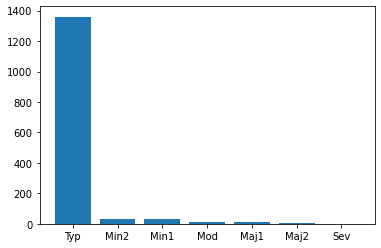

In [67]:
plt.bar(x = list(data['Functional'].value_counts().reset_index()['index']), 
        height = list(data['Functional'].value_counts().reset_index()['Functional']));

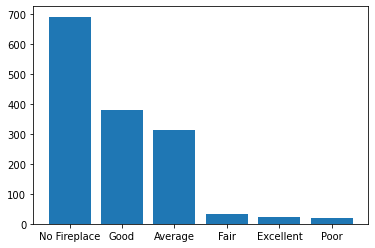

In [68]:
plt.bar(x = list(data['FireplaceQu'].value_counts().reset_index()['index']), 
        height = list(data['FireplaceQu'].value_counts().reset_index()['FireplaceQu']));

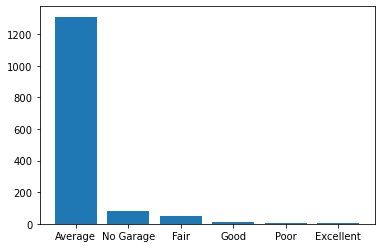

In [69]:
plt.bar(x = list(data['GarageQual'].value_counts().reset_index()['index']), 
        height = list(data['GarageQual'].value_counts().reset_index()['GarageQual']));

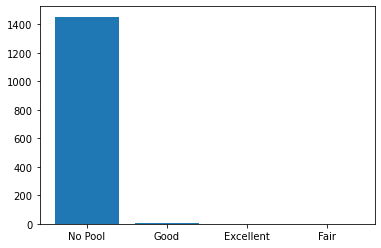

In [70]:
plt.bar(x = list(data['PoolQC'].value_counts().reset_index()['index']), 
        height = list(data['PoolQC'].value_counts().reset_index()['PoolQC']));

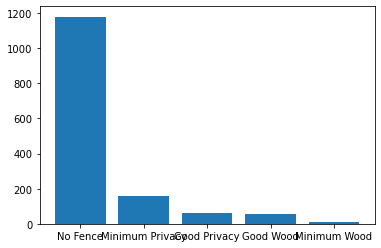

In [71]:
plt.bar(x = list(data['Fence'].value_counts().reset_index()['index']), 
        height = list(data['Fence'].value_counts().reset_index()['Fence']));

The reason I made a bar graph for most of the categorical features is to help me with my next phase which is predictive modeling. By graphing these categorical features, I can easily see which features have variance. The graphs that have more variance would be more helpful than those whose graphs aren't variant. From all the graphs above, it seems that the categorical features that will be helful for modeling is LotShape, HouseStyle, Exterior1st, Foundation, BsmtQual, BsmtFinType1, HeatingQC, KitchenQual, and FireplaceQu. 

Now, let's create two new features called 'TotalFlrSF' (which is equal to '1stFlrSF' plus '2ndFlrSF) and 'TotalBaths' (which is equal to 'BsmtFullBath' + 'FullBath' + .5('BsmtHalfBath' + 'HalfBath')).

In [92]:
data['TotalFlrSF'] = data['1stFlrSF'] + data['2ndFlrSF']
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalFlrSF
0,1,60,RL,65.0,8450,Pave,No alley access,Reg,Lvl,AllPub,...,No Pool,No Fence,None,0,2,2008,WD,Normal,208500,1710
1,2,20,RL,80.0,9600,Pave,No alley access,Reg,Lvl,AllPub,...,No Pool,No Fence,None,0,5,2007,WD,Normal,181500,1262
2,3,60,RL,68.0,11250,Pave,No alley access,IR1,Lvl,AllPub,...,No Pool,No Fence,None,0,9,2008,WD,Normal,223500,1786
3,4,70,RL,60.0,9550,Pave,No alley access,IR1,Lvl,AllPub,...,No Pool,No Fence,None,0,2,2006,WD,Abnorml,140000,1717
4,5,60,RL,84.0,14260,Pave,No alley access,IR1,Lvl,AllPub,...,No Pool,No Fence,None,0,12,2008,WD,Normal,250000,2198


In [102]:
half = data['BsmtHalfBath'] + data['HalfBath']
data['TotalBaths'] = data['BsmtFullBath'] + data['FullBath'] + (half/2)

In [103]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalFlrSF,TotalBaths
0,1,60,RL,65.0,8450,Pave,No alley access,Reg,Lvl,AllPub,...,No Fence,None,0,2,2008,WD,Normal,208500,1710,3.5
1,2,20,RL,80.0,9600,Pave,No alley access,Reg,Lvl,AllPub,...,No Fence,None,0,5,2007,WD,Normal,181500,1262,2.5
2,3,60,RL,68.0,11250,Pave,No alley access,IR1,Lvl,AllPub,...,No Fence,None,0,9,2008,WD,Normal,223500,1786,3.5
3,4,70,RL,60.0,9550,Pave,No alley access,IR1,Lvl,AllPub,...,No Fence,None,0,2,2006,WD,Abnorml,140000,1717,2.0
4,5,60,RL,84.0,14260,Pave,No alley access,IR1,Lvl,AllPub,...,No Fence,None,0,12,2008,WD,Normal,250000,2198,3.5


We can move on to our next phase which is predictive modeling.

In [104]:
y = data.SalePrice
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [105]:
X_cols = ['LotArea','LotShape', 'HouseStyle', 'OverallQual', 'Exterior1st', 'Foundation', 'BsmtQual', 'BsmtFinType1',
         'TotalBsmtSF', 'HeatingQC', 'TotalFlrSF', 'TotalBaths', 'KitchenQual', 'FireplaceQu']
X = data[X_cols]
X

,LotArea,LotShape,HouseStyle,OverallQual,Exterior1st,Foundation,BsmtQual,BsmtFinType1,TotalBsmtSF,HeatingQC,TotalFlrSF,TotalBaths,KitchenQual,FireplaceQu
0,8450,Reg,2Story,7,VinylSd,PConc,Good,Good Living Quarters,856,Ex,1710,3.5,Gd,No Fireplace
1,9600,Reg,1Story,6,MetalSd,CBlock,Good,Average Living Quarters,1262,Ex,1262,2.5,TA,Average
2,11250,IR1,2Story,7,VinylSd,PConc,Good,Good Living Quarters,920,Ex,1786,3.5,Gd,Average
3,9550,IR1,2Story,7,Wd Sdng,BrkTil,Average,Average Living Quarters,756,Gd,1717,2.0,Gd,Good
4,14260,IR1,2Story,8,VinylSd,PConc,Good,Good Living Quarters,1145,Ex,2198,3.5,Gd,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,Reg,2Story,6,VinylSd,PConc,Good,Unfinished,953,Ex,1647,2.5,TA,Average
1456,13175,Reg,1Story,6,Plywood,CBlock,Good,Average Living Quarters,1542,TA,2073,3.0,TA,Average
1457,9042,Reg,2Story,7,CemntBd,Stone,Average,Good Living Quarters,1152,Ex,2340,2.0,Gd,Good
1458,9717,Reg,1Story,5,MetalSd,CBlock,Average,Good Living Quarters,1078,Gd,1078,2.0,Gd,No Fireplace


Since most of our features are categorical, we need to use a method called one-hot encoding to transform them into usable numeric data.  

In [106]:
def ohe(dataframe, column):
    val_count = dataframe[column].value_counts().reset_index() #returns a dataframe of the different values of the column
    ratings = np.array(val_count['index']) #returns an array of the different ratings (excellent, good, average, etc...)
    for rating in ratings: #adds a column for each rating and sets it to 1 if the rating is equal and 0 if not
        for i in np.arange(len(dataframe)):
            if dataframe.loc[i, column] == rating: 
                dataframe.loc[i, column + ' = ' + rating] = 1
            else:
                dataframe.loc[i, column + ' = ' + rating] = 0
    dataframe.drop(column, inplace = True, axis = 1)
    return dataframe

In [107]:
X = ohe(X, 'LotShape')
X = ohe(X, 'HouseStyle')
X = ohe(X, 'Exterior1st')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [108]:
X = ohe(X, 'Foundation')
X = ohe(X, 'BsmtQual')
X = ohe(X, 'BsmtFinType1')

In [109]:
X = ohe(X, 'HeatingQC')
X = ohe(X, 'KitchenQual')
X = ohe(X, 'FireplaceQu')

In [110]:
X.head()

,LotArea,OverallQual,TotalBsmtSF,TotalFlrSF,TotalBaths,LotShape = Reg,LotShape = IR1,LotShape = IR2,LotShape = IR3,HouseStyle = 1Story,...,KitchenQual = TA,KitchenQual = Gd,KitchenQual = Ex,KitchenQual = Fa,FireplaceQu = No Fireplace,FireplaceQu = Good,FireplaceQu = Average,FireplaceQu = Fair,FireplaceQu = Excellent,FireplaceQu = Poor
0,8450,7,856,1710,3.5,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9600,6,1262,1262,2.5,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11250,7,920,1786,3.5,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9550,7,756,1717,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,14260,8,1145,2198,3.5,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now, we need to split our data into train and test.

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

In [112]:
X_train

,LotArea,OverallQual,TotalBsmtSF,TotalFlrSF,TotalBaths,LotShape = Reg,LotShape = IR1,LotShape = IR2,LotShape = IR3,HouseStyle = 1Story,...,KitchenQual = TA,KitchenQual = Gd,KitchenQual = Ex,KitchenQual = Fa,FireplaceQu = No Fireplace,FireplaceQu = Good,FireplaceQu = Average,FireplaceQu = Fair,FireplaceQu = Excellent,FireplaceQu = Poor
254,8400,5,1314,1314,2.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1066,7837,6,799,1571,2.5,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
638,8777,5,796,796,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
799,7200,5,731,1768,2.5,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
380,5000,5,1026,1691,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,9317,6,1314,1314,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1130,7804,4,1122,1981,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1294,8172,5,864,864,2.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
860,7642,7,912,1426,1.5,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [113]:
y_train

254     145000
1066    178000
638      85000
799     175000
380     127000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 1168, dtype: int64

In [114]:
X_test

,LotArea,OverallQual,TotalBsmtSF,TotalFlrSF,TotalBaths,LotShape = Reg,LotShape = IR1,LotShape = IR2,LotShape = IR3,HouseStyle = 1Story,...,KitchenQual = TA,KitchenQual = Gd,KitchenQual = Ex,KitchenQual = Fa,FireplaceQu = No Fireplace,FireplaceQu = Good,FireplaceQu = Average,FireplaceQu = Fair,FireplaceQu = Excellent,FireplaceQu = Poor
892,8414,6,1059,1068,1.5,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1105,12256,8,1463,2622,3.5,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
413,8960,5,1008,1028,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
522,5000,6,1004,1664,2.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1036,12898,9,1620,1620,3.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,5925,4,907,1131,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1361,16158,7,1530,1530,3.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
802,8199,7,728,1456,3.5,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
651,9084,4,755,1510,2.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [115]:
y_test

892     154500
1105    325000
413     115000
522     159000
1036    315500
         ...  
479      89471
1361    260000
802     189000
651     108000
722     124500
Name: SalePrice, Length: 292, dtype: int64

Now, we will define a model. I will be defining a linear model since a linear model predicts continuous-valued outcomes best. 

In [116]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression()

Then, we will fit the training data.

In [117]:
linear_model.fit(X_train, y_train)
linear_model.score(X_train, y_train)

0.8242383930959938

As you can see, our accuracy for the model is pretty good. However, we should make sure our model isn't overfitting nor underfitting. We can do so by doing cross validation.  

In [121]:
from sklearn.model_selection import cross_val_score
cross_val_score_train = cross_val_score(linear_model, X_train, y_train, cv=10)
print(cross_val_score_train)

[0.85084999 0.82710419 0.87722917 0.60634397 0.47986034 0.82091952
 0.85749126 0.85530706 0.83832531 0.84404515]


In [122]:
average_cross_score = np.mean(cross_val_score_train)
print(average_cross_score)

0.785747596125361


Since the cross validation score isn't significantly smaller or larger than our train accuracy score, we aren't underfitting nor overfitting. We can move on to adding more features.

In [120]:
linear_model.score(X_test, y_test)

0.8330605115623142